In [1]:
import json
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
from torch_geometric.utils import to_dense_batch
import torch.optim as optim
import json

sys.path.append(os.path.abspath(".."))
from functions.utils_L2D import load_and_restore_parquet, display_frames

In [2]:
#pip freeze > requirements.txt

## Phase 1: Generating the Graphs

#### 1. Download Data

- To download only one episode, use data_downloader(ep_num,...)

- To download a range of episodes, use data_downloader(min_ep,max_ep,...)

- Additionally, you can chnge the following directories:

    - tabular_data_dir = '../data/raw/L2D/tabular'

    - frames_dir = '../data/raw/L2D/frames'

In [3]:
from functions.load_data_L2D import data_downloader

data_downloader(32,n_secs=3,
                features={"tabular": True,
                          "frames": {
                                'observation.images.front_left': True,
                                'observation.images.left_backward': False,
                                'observation.images.left_forward': False,
                                'observation.images.map': False,
                                'observation.images.rear': False,
                                'observation.images.right_backward': False,
                                'observation.images.right_forward': False,
                            }
                        })

In [4]:
df = load_and_restore_parquet('../data/raw/L2D/tabular/episode_000032.parquet')
df.head()

,observation.state.vehicle,observation.state.waypoints,observation.state.timestamp,task.policy,task.instructions,action.continuous,action.discrete,timestamp,frame_index,episode_index,index,task_index
0,"[28.851562, 43.10965, 0.57818, 51.78767, 6.129...","[[6.129905, 51.78773], [6.130005, 51.7878], [6...",1724930626022292165,EXPERT,"At the next right turn coming up, turn right i...","[0.027559055, 0.0, -0.016041668]","[3, 2]",0.0,0,32,9971,0
1,"[17.84375, 39.822693, 0.96858, 51.787807, 6.13...","[[6.130089, 51.787872], [6.130186, 51.787933],...",1724930629023321302,EXPERT,"At the next right turn coming up, turn right i...","[0.0, 0.14634146, -0.00083333335]","[3, 2]",3.0,30,32,10001,0
2,"[15.234375, 58.068726, 1.21599, 51.78789, 6.13...","[[6.130186, 51.787933], [6.130324, 51.787937],...",1724930632024396972,EXPERT,"At the next right turn coming up, turn right i...","[0.098425195, 0.0, 0.34604168]","[3, 2]",6.0,60,32,10031,0
3,"[21.367188, 89.08917, 0.85741, 51.78791, 6.130...","[[6.130468, 51.78793], [6.130612, 51.787933], ...",1724930635025387272,EXPERT,"At the next right turn coming up, turn right i...","[0.1496063, 0.0, -0.008125001]","[3, 0]",9.0,90,32,10061,0
4,"[26.15625, 84.18417, 0.76451, 51.787918, 6.130...","[[6.130757, 51.78794], [6.130902, 51.787945], ...",1724930638026407226,EXPERT,"At the next right turn coming up, turn right i...","[0.047244094, 0.0, -0.008541667]","[3, 0]",12.0,120,32,10091,0


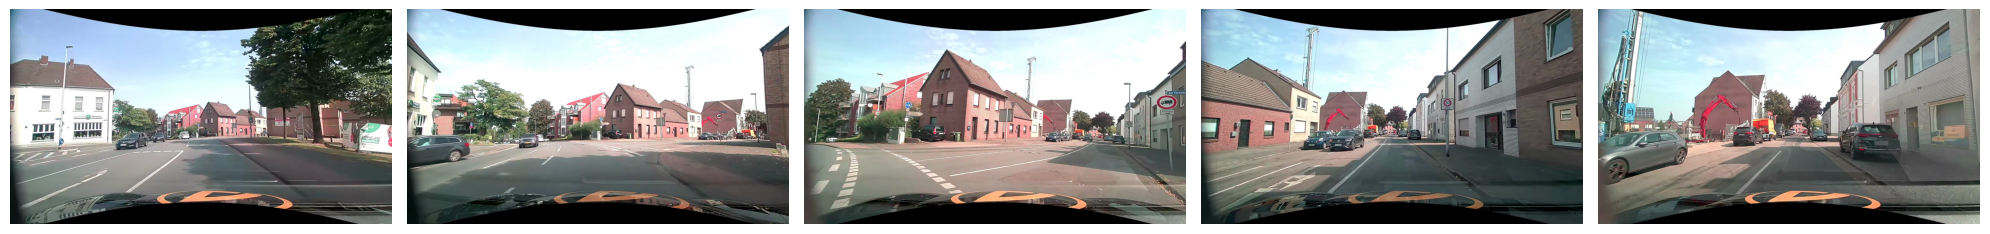

In [5]:
display_frames('../data/raw/L2D/frames/Episode000032/observation.images.front_left')

#### 2. Process Tabular Data & Add Tags

- To process only one episode, use process_tabular_data(ep_num,...)

- To process a range of episodes, use process_tabular_data(min_ep,max_ep,...)

- Additionally, you can change the following directories:

    - process_tabular_data:

        - source_dir = '../data/raw/L2D/tabular'

        - output_dir_processed = '../data/processed_data/L2D'

        - output_dir_tags = '../data/semantic_tags/L2D'

    - add_data_tags:

        - data_dir = '../data/processed/L2D'

        - tags_dir='../data/semantic_tags/L2D'

In [6]:
from functions.process_tabular_data_L2D import process_tabular_data
from functions.process_tags_L2D import add_data_tags

process_tabular_data(32,
                    overwrite=False, process_columns=True, 
                    process_osm=True, process_turning=False)
add_data_tags(32)

100%|██████████| 1/1 [00:00<00:00, 58.26it/s]


In [7]:
df = load_and_restore_parquet('../data/processed/L2D/episode_000032.parquet')
df.head()

,vehicle_speed,vehicle_heading,vehicle_heading_error,vehicle_latitude,vehicle_longitude,vehicle_altitude,vehicle_acceleration_x,vehicle_acceleration_y,waypoints,action_gas_pedal,...,bicycle,bridge,tunnel,traffic_controls,traffic_features,landuse,is_narrow,is_unlit,bike_friendly,turning_behavior
0,28.851562,43.109650,0.57818,51.787670,6.129874,51.787670,0.38,-0.29,"[{'x': 6.1299052238464355, 'y': 51.78773117065...",0.027559,...,None,no,no,None,None,residential,None,False,False,straight
1,17.843750,39.822693,0.96858,51.787807,6.130071,51.787807,-0.08,-1.20,"[{'x': 6.130088806152344, 'y': 51.787872314453...",0.000000,...,no,no,no,None,None,residential,None,False,False,straight
2,15.234375,58.068726,1.21599,51.787891,6.130204,51.787891,-2.05,-0.59,"[{'x': 6.130186080932617, 'y': 51.787933349609...",0.098425,...,no,no,no,None,pedestrian_crossing,residential,None,False,False,turning right
3,21.367188,89.089172,0.85741,51.787910,6.130410,51.787910,-0.16,0.74,"[{'x': 6.130467891693115, 'y': 51.787929534912...",0.149606,...,no,no,no,None,pedestrian_crossing,residential,None,False,False,straight
4,26.156250,84.184174,0.76451,51.787918,6.130705,51.787918,-0.07,0.00,"[{'x': 6.130756855010986, 'y': 51.787940979003...",0.047244,...,None,no,no,None,None,residential,None,False,False,straight


In [10]:
with open('../data/semantic_tags/L2D/episode_000032.json', 'r') as f:
    tags = json.load(f)
tags

{'policy': 'EXPERT',
 'instructions': 'At the next right turn coming up, turn right into the 30 kph zone',
 'time steps': '3.0 seconds',
 'legnth': '15.0 seconds, 5 frames',
 'action_tag': 'right_turn',
 'traffic_control_tag': 'unmarked',
 'road_feature_tags': ['pedestrian_area', 'urban'],
 'environment_tags': ['off_peak_hours']}

#### 3. Process Frames (Under Construction)

- Set up with depth model with pip install git+https://github.com/apple/ml-depth-pro.git

- To process only one episode, use process_frames(ep_num,...)

- To process a range of episodes, use process_frames(min_ep,max_ep,...)

- Additionally, you can change the following directories:

    - input_base_dir = '../data/raw/L2D/frames',
    
    - output_base_dir = '../data/processed_frames/L2D'

- You can also include the following cameras:

    - "observation.images.front_left",
    - "observation.images.left_forward", 
    - "observation.images.right_forward",
    - "observation.images.right_backward",
    - "observation.images.rear",
    - "observation.images.left_backward"

**Note**: Including additional cameras will help with the depth, speed, etc. but CONSIDERABLY increases running time.

In [19]:
from functions.process_frames_L2D import process_frames

process_frames(32,
               cameras_on=["observation.images.front_left"],
               run_dict={"detection": True,
                         "depth": True,
                         "speed": True},
                verbose=True)


=== Setting up DepthPro ===


For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.


✅ Model downloaded successfully to: ml-depth-pro/checkpoints/depth_pro.pt
✅ Depth Pro available
PyTorch: 2.7.1
CUDA available: False
✅ Depth Pro model found
🔍 Initializing Depth Pro...
✅ Depth Pro model already exists
✅ Depth Pro loaded on cpu

=== Initializing RF-DETR Model ===
🤖 Initializing RF-DETR model...
Loading pretrain weights
✅ RF-DETR model loaded successfully

🔹 Processing episode 32 with config: {'detection': True, 'depth': True, 'speed': True}
  📷 Camera front_left: 5 frames found


Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


Error in RF-DETR detection: The operator 'aten::_upsample_bicubic2d_aa.out' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash e2d141dbde55c2a4370fac5165b0561b6af4798b. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.
Error in RF-DETR detection: The operator 'aten::_upsample_bicubic2d_aa.out' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash e2d141dbde55c2a4370fac5165b0561b6af4798b. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use 

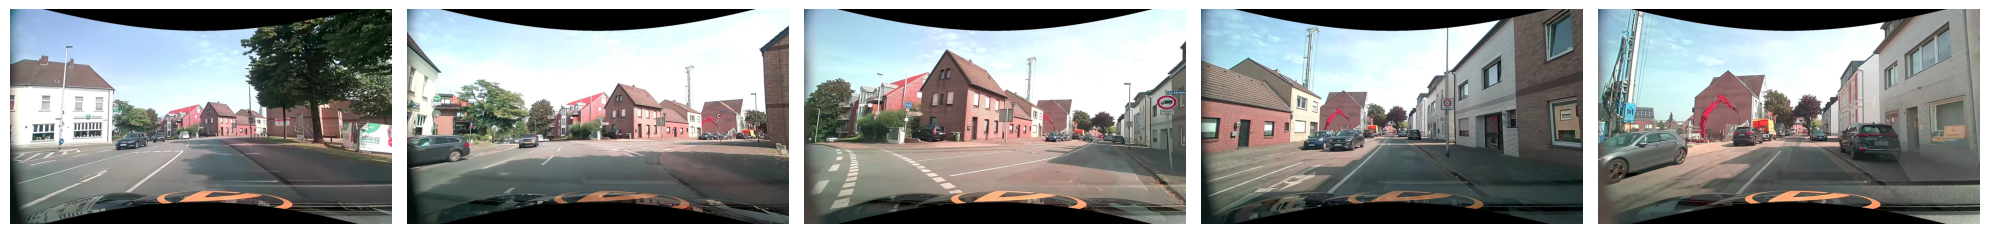

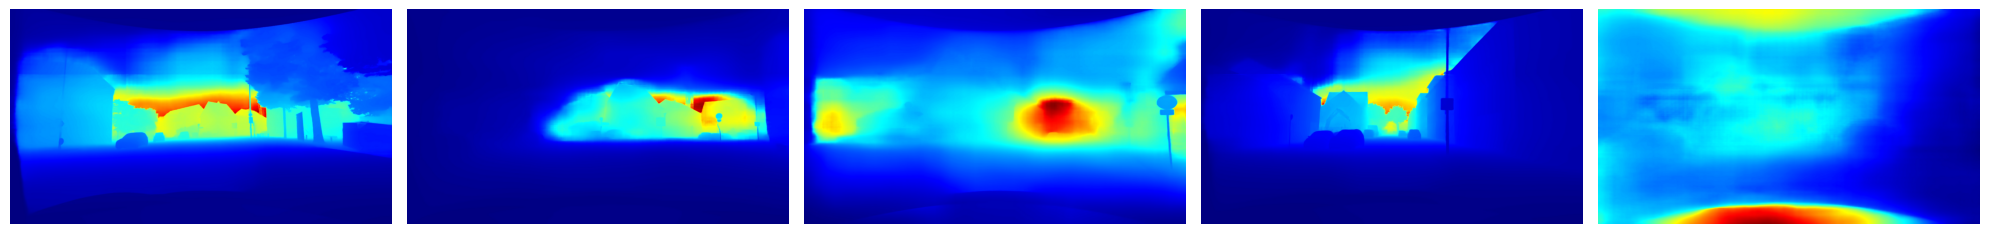

In [ ]:
display_frames('../data/processed_frames/L2D/Episode000032/front_left_Segmented')
display_frames('../data/processed_frames/L2D/Episode000032/front_left_DepthColormaps')

In [15]:
with open('../data/processed_frames/L2D/Episode000032/front_left_Annotations/frame_00000.json', 'r') as f:
    annotations = json.load(f)
annotations

{'info': {'description': 'L2D Dataset Detection Results',
  'date_created': '2025-08-04 22:18:27'},
 'images': [{'id': 1,
   'file_name': 'frame_00000.jpg',
   'width': 1920,
   'height': 1080,
   'camera': 'front_left',
   'has_depth': True}],
 'annotations': [],
 'categories': [{'id': 1, 'name': 'vehicle', 'supercategory': 'traffic'},
  {'id': 2, 'name': 'pedestrian', 'supercategory': 'traffic'}]}

#### 4. Generate Graphs

- To process only one episode, use generate_graphs(ep_num,...)

- To process a range of episodes, use generate_graphs(min_ep,max_ep,...)

- Additionally, you can change the following directories:

    - source_data_dir = '../data/processed/L2D',
    
    - processed_frame_dir = '../data/processed_frames/L2D',
                    
    - output_dir = '../data/graphical/L2D'

In [16]:
from functions.graphs_L2D import generate_graphs

generate_graphs(32)

In [3]:
from functions.graphs_L2D import combined_graph_viewer

ep_num = 23
with open(f"../data/graphical/L2D/{ep_num}_graph.json", "r") as f:
    graph_data = json.load(f)

cyto = combined_graph_viewer({'graph':graph_data})
display(cyto)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'label': 'd…

## Phase 2: Training Models without Diffusion

In [18]:
import json
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
from torch_geometric.utils import to_dense_batch
import torch.optim as optim
import json

sys.path.append(os.path.abspath(".."))
from functions.utils_L2D import load_and_restore_parquet, display_frames

### A. Classification Task Loss

#### 1. Load the Graphical Data

- feature_keys allows us to select which features to include in the loaded data

- num_steps is for standardizing the episode lenght. All episodes will be cut off at this length

- If skip_short is set to true, then the episodes that are shorter than num_steps will not be loaded

In [ ]:
from functions.graphs_L2D import create_dataloaders

train_loader, test_loader, train_set, test_set = create_dataloaders(
    directory="../data/graphical/L2D/",
    feature_keys=['speed', 'heading', 'accel_x', 'accel_y', 'latitude', 'longitude'],
    num_steps=5,
    skip_short=True,
    batch_size=64
)

#### 2. Initialize Models

In [ ]:
from functions.models_L2D import GraphPipeline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphPipeline(in_dim=6, trans_dim=16, gnn_hidden=32, graph_emb_dim=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

batch = next(iter(train_loader)).to(device)
out = model(batch.x, batch.edge_index, batch.batch)

print("Graph embedding shape:", out.shape)

#### 3. Train Models Jointly

In [ ]:
from functions.models_L2D import train, evaluate

num_epochs = 5
for epoch in range(1, num_epochs+1):
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    test_loss = evaluate(model, test_loader, loss_fn, device)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")